Nick von Bulow

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Topic Modeling: Latent Dirichlet Allocation with sklearn
## Imports and settings

In [2]:
%matplotlib inline

from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import joblib

In [3]:
sns.set_style('white')
plt.rcParams['figure.figsize'] = (14, 8.7)

In [4]:
pyLDAvis.enable_notebook()

In [5]:
DATA_DIR = Path('../data')
data_path = DATA_DIR / 'bbc'
results_path = Path('results')
model_path = Path('results', 'bbc')
if not model_path.exists():
    model_path.mkdir(exist_ok=True, parents=True)

## Load BBC Data
We are training an LDA model with 5 topics

In [6]:
files = sorted(list(data_path.glob('**/*.txt')))
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

# Converting this files into a dataframe
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
display(docs.head())
print(docs.info())

,topic,heading,article
0,Business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,Business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,Business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,Business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,Business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   topic    2225 non-null   object
 1   heading  2225 non-null   object
 2   article  2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB
None


## Create Training and Testing Sets

In [7]:
train_docs, test_docs = train_test_split(docs, stratify=docs['topic'], test_size=0.2, random_state=42)
train_docs.shape, test_docs.shape

((1780, 3), (445, 3))

In [8]:
test_docs['topic'].value_counts()

Business         102
Sport            102
Politics          84
Tech              80
Entertainment     77
Name: topic, dtype: int64

### Vectorizing train and test sets

In [9]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.11, min_df=0.026)

train_dtm = vectorizer.fit_transform(train_docs['article'])
words = vectorizer.get_feature_names()
train_dtm

<1780x1090 sparse matrix of type '<class 'numpy.float64'>'
	with 95125 stored elements in Compressed Sparse Row format>

In [10]:
test_dtm = vectorizer.transform(test_docs['article'])
words = vectorizer.get_feature_names()
test_dtm

<445x1090 sparse matrix of type '<class 'numpy.float64'>'
	with 24357 stored elements in Compressed Sparse Row format>

## LDA with sklearn

In [11]:
n_components = 5
topic_labels = [f'Topic {i+1}' for i in range(n_components)]
lda_base = LatentDirichletAllocation(n_components=n_components, max_iter=10, learning_method='batch', n_jobs=-1)
lda_base.fit(train_dtm)

LatentDirichletAllocation(n_components=5, n_jobs=-1)

### Persist model

In [12]:
joblib.dump(lda_base, f'{model_path}/lda_base.pkl')

['results\\bbc/lda_base.pkl']

In [13]:
# We can also unpickle the model from disk!
lda_base = joblib.load(f'{model_path}/lda_base.pkl')
lda_base

LatentDirichletAllocation(n_components=5, n_jobs=-1)

## Explore topics and word distributions

In [14]:
# pseudo counts
topics_count = lda_base.components_
print(topics_count.shape)
topics_count[:5]

(5, 1090)


array([[0.20038671, 0.2022282 , 0.20023083, ..., 0.2003482 , 0.20025544,
        0.20028767],
       [6.29708305, 5.83796568, 7.53133534, ..., 0.23298745, 4.99672728,
        0.74155944],
       [4.11185507, 2.71630264, 2.23171454, ..., 6.08096061, 1.91785396,
        5.03391021],
       [0.98390829, 4.23094675, 2.83672929, ..., 0.77003276, 4.99468754,
        4.98308169],
       [1.21052785, 2.18244558, 3.40223573, ..., 1.7049542 , 1.54848957,
        3.57455812]])

In [15]:
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
100,0.000819,0.001706,0.001157,0.000606,0.000470
11,0.000826,0.001582,0.000764,0.002608,0.000847
12,0.000818,0.002041,0.000628,0.001748,0.001321
13,0.000820,0.001067,0.000232,0.002044,0.001198
14,0.000826,0.001084,0.000636,0.001160,0.001062


In [16]:
# do all the words have positive probability for all topics
topics[topics.gt(0).all(1)].shape[0] == topics.shape[0]

True

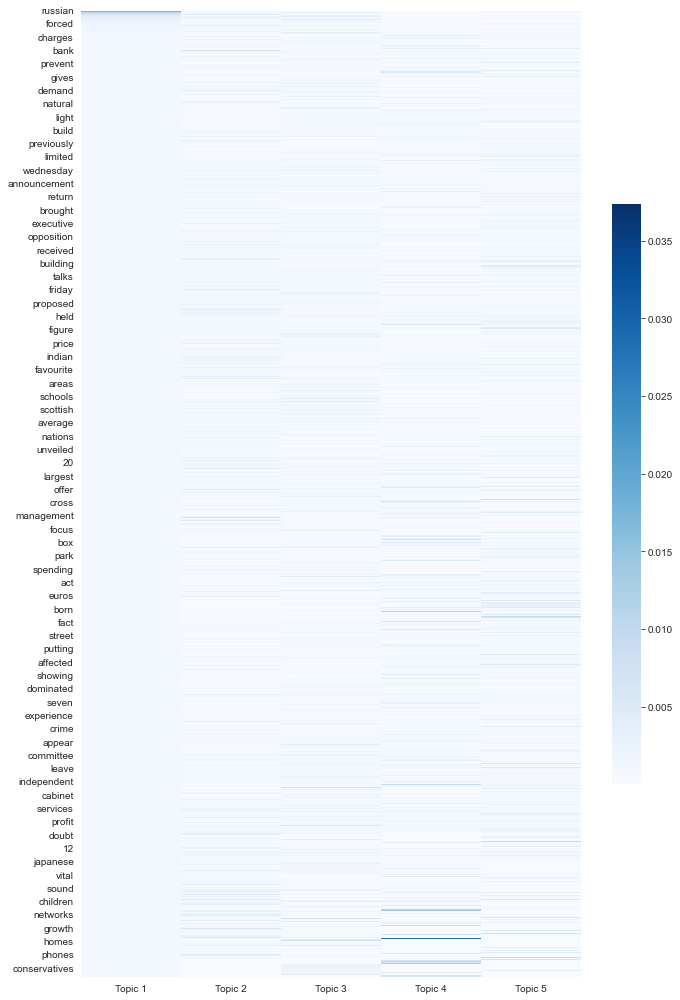

In [17]:
fig, ax = plt.subplots(figsize=(10, 14))
sns.heatmap(topics.sort_values(topic_labels, ascending=False),
            cmap='Blues', ax=ax, cbar_kws={'shrink': .6})
fig.tight_layout()

In [18]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,russian,sales,labour,film,club
1,russia,growth,blair,music,match
2,court,bank,election,awards,cup
3,unit,mobile,party,award,injury
4,oil,economy,brown,band,season
5,political,technology,howard,album,ireland
6,tax,china,prime,star,final
7,sale,shares,tax,films,chelsea
8,legal,digital,campaign,actor,coach
9,protection,oil,law,singer,rugby


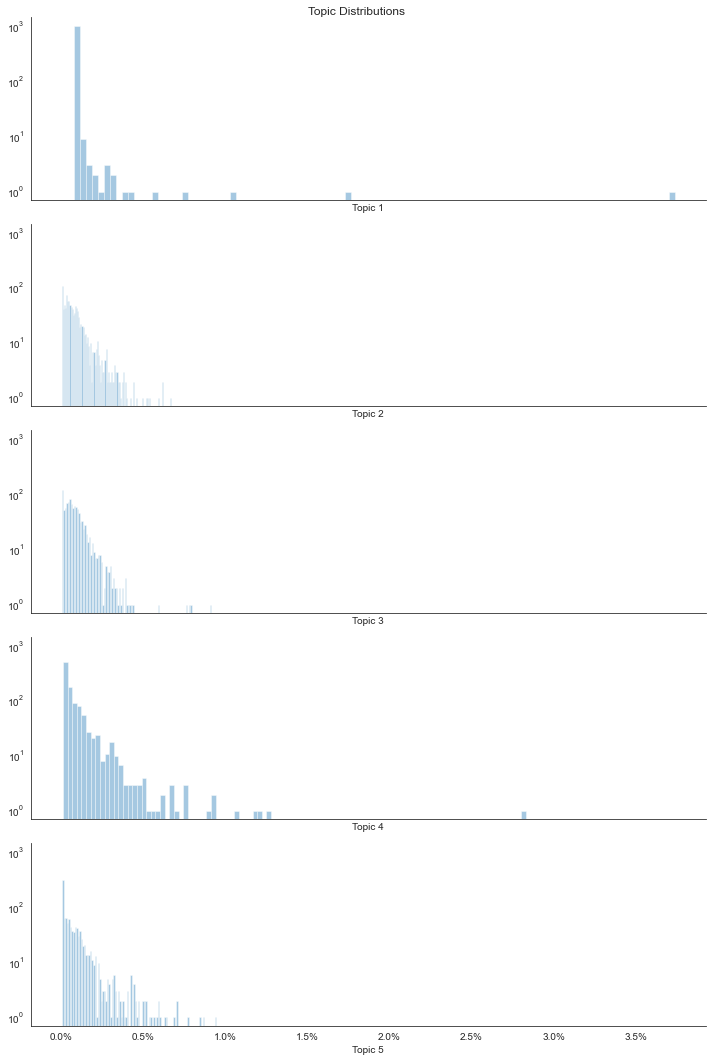

In [19]:
fig, axes = plt.subplots(nrows=5, sharey=True, sharex=True, figsize=(10, 15))
for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob, ax=axes[i], bins=100, kde=False, norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
sns.despine()
fig.tight_layout()

## Evaluate Fit on Train Set

In [20]:
train_preds = lda_base.transform(train_dtm)
train_preds.shape

(1780, 5)

In [21]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)
train_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Business,0.027646,0.887795,0.028113,0.027984,0.028463
Sport,0.033246,0.034072,0.033852,0.033922,0.864908
Entertainment,0.031877,0.318116,0.237532,0.380142,0.032334
Politics,0.023014,0.023502,0.906967,0.023217,0.023300
Politics,0.027458,0.030420,0.854091,0.028060,0.059971


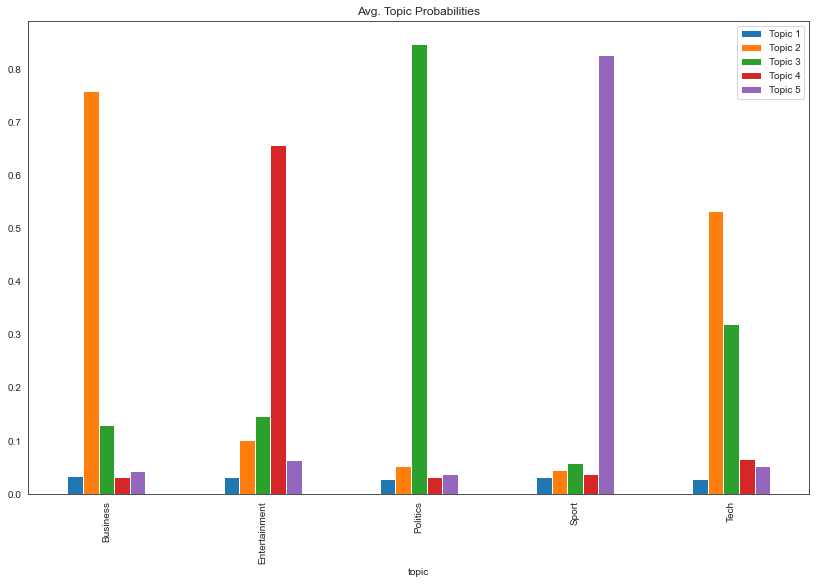

In [22]:
train_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities');

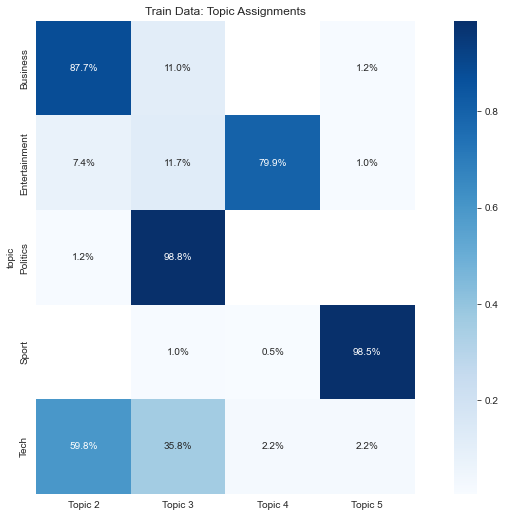

In [23]:
df = train_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Topic Assignments');

## Evaluate Fit on Test Set

In [24]:
test_preds = lda_base.transform(test_dtm)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_docs.topic)
test_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Business,0.025824,0.894400,0.027130,0.026189,0.026457
Business,0.033988,0.834242,0.059124,0.034982,0.037663
Entertainment,0.027172,0.027481,0.029582,0.887995,0.027770
Business,0.024566,0.900011,0.025729,0.024759,0.024935
Business,0.028467,0.864026,0.029007,0.049823,0.028677


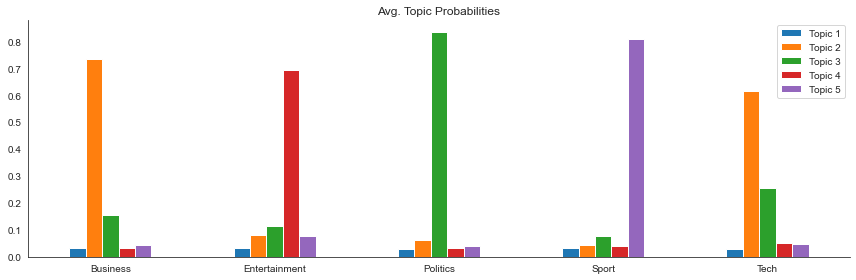

In [25]:
test_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities',
                                                 figsize=(12, 4),
                                                 rot=0)
plt.xlabel('')
sns.despine()
plt.tight_layout()

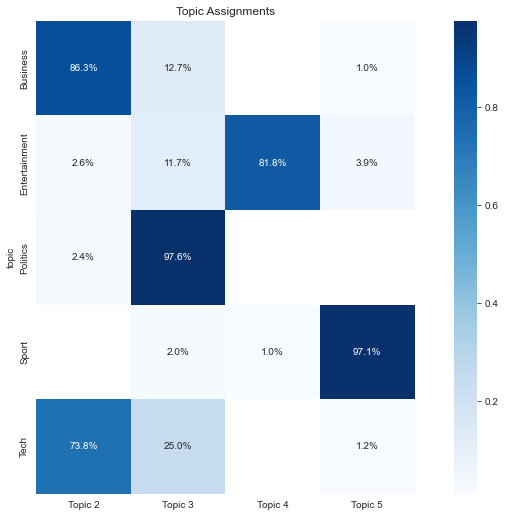

In [26]:
df = test_eval.groupby(level='topic').idxmax(axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True).unstack(-1), 
            annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Topic Assignments');

## Retrain until perplexity no longer decreases

In [27]:
lda_opt = LatentDirichletAllocation(n_components=5,
                                    n_jobs=-1,
                                    max_iter=500,
                                    learning_method='batch',
                                    evaluate_every=5,
                                    verbose=1,
                                    random_state=42)
lda_opt.fit(train_dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 2042.0426
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 1998.1965
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 1993.5417
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 1992.8113
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 1992.5806
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter:

LatentDirichletAllocation(evaluate_every=5, max_iter=500, n_components=5,
                          n_jobs=-1, random_state=42, verbose=1)

In [28]:
joblib.dump(lda_opt, model_path / 'lda_opt.pkl')
lda_opt = joblib.load(model_path / 'lda_opt.pkl')

In [29]:
train_opt_eval = pd.DataFrame(data=lda_opt.transform(train_dtm),
                              columns=topic_labels,
                              index=train_docs.topic)
test_opt_eval = pd.DataFrame(data=lda_opt.transform(test_dtm),
                             columns=topic_labels, 
                             index=test_docs.topic)

display(train_opt_eval.groupby(level='topic').mean())
display(test_opt_eval.groupby(level='topic').mean())

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Business,0.029249,0.792477,0.098875,0.043708,0.035690
Entertainment,0.031236,0.138121,0.119353,0.072196,0.639095
Politics,0.027619,0.088867,0.806993,0.041894,0.034627
Sport,0.031159,0.051306,0.069660,0.809540,0.038335
Tech,0.028150,0.743868,0.055020,0.049313,0.123649


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Business,0.027591,0.787692,0.107731,0.041985,0.035001
Entertainment,0.032018,0.110971,0.106699,0.090468,0.659843
Politics,0.027588,0.104797,0.783204,0.049320,0.035091
Sport,0.031306,0.048633,0.083304,0.797661,0.039096
Tech,0.028428,0.759700,0.049646,0.048017,0.114209


## Compare Train and test Topic assignments

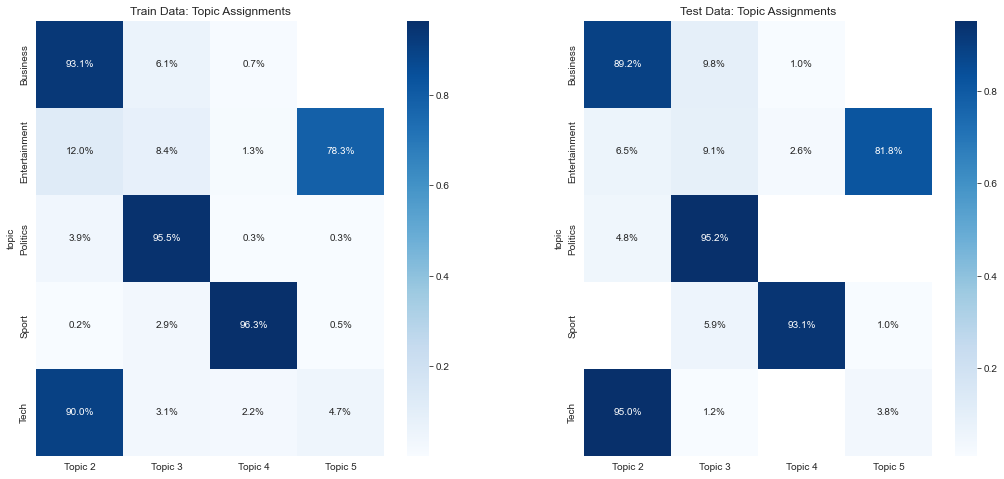

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 8))
source = ['Train', 'Test']
for i, df in enumerate([train_opt_eval, test_opt_eval]):
    df = df.groupby(level='topic').idxmax(axis=1).reset_index(-1, drop=True)
    sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
                .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i])
    axes[i].set_title('{} Data: Topic Assignments'.format(source[i]))

## Explore miclassified articles

In [31]:
test_assignments = test_docs.assign(predicted=test_opt_eval.idxmax(axis=1).values)
test_assignments.head()

,topic,heading,article,predicted
263,Business,French suitor holds LSE meeting,European stock market Euronext has met with t...,Topic 2
363,Business,Durex maker SSL awaits firm bid,UK condom maker SSL International has refused...,Topic 2
605,Entertainment,Singer's film to show at festival,A documentary which takes a candid look at th...,Topic 5
106,Business,Liberian economy starts to grow,"The Liberian economy started to grow in 2004,...",Topic 2
359,Business,Record year for Chilean copper,Chile's copper industry has registered record...,Topic 2


In [32]:
misclassified = test_assignments[(test_assignments.topic == 'Entertainment') & (
    test_assignments.predicted == 'Topic 4')]
misclassified.heading

695     Johnny and Denise lose Passport
831    Pixies take on Reading and Leeds
Name: heading, dtype: object

## PyLDAVis

In [33]:
vectorizer = CountVectorizer(max_df=.5, 
                             min_df=5,
                             stop_words='english',
                             max_features=2000)
dtm = vectorizer.fit_transform(docs.article)

In [34]:
lda_all = LatentDirichletAllocation(n_components=5,
                                    max_iter=500,
                                    learning_method='batch',
                                    evaluate_every=10,
                                    random_state=42,
                                    verbose=1)
lda_all.fit(dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 1019.9467
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 1006.8139
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter: 500
iteration: 30 of max_iter: 500, perplexity: 1003.1615
iteration:

LatentDirichletAllocation(evaluate_every=10, max_iter=500, n_components=5,
                          random_state=42, verbose=1)

In [35]:
joblib.dump(lda_all, model_path /'lda_all.pkl')
lda_all = joblib.load(model_path / 'lda_all.pkl') 

In [36]:
prepare(lda_all, dtm, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.073450  0.078507       1        1  25.501837
3      0.095719 -0.098360       2        1  21.840844
0      0.141084  0.011426       3        1  20.954199
4     -0.142908  0.141046       4        1  18.692064
1     -0.167345 -0.132619       5        1  13.011057, topic_info=         Term         Freq        Total Category  logprob  loglift
1200       mr  2987.000000  2987.000000  Default  30.0000  30.0000
724      film   838.000000   838.000000  Default  29.0000  29.0000
230      best   960.000000   960.000000  Default  28.0000  28.0000
1022   labour   770.000000   770.000000  Default  27.0000  27.0000
780      game   855.000000   855.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1081   london   145.604869   454.658340   Topic5  -5.5414   0.9007
1816     time   158.747400  1303.506427   Topic5  -5.4550  -0.0661
1607   series   135.441328   252.071835   Topic5  -5.6138   1.4182
1977    world   147.425268  1173.233921   Topic5  -5.5290  -0.0348
1165  million   135.595694   574.095651   Topic5  -5.6126   0.5963

[353 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.270257      000
0         2  0.219976      000
0         3  0.382130      000
0         4  0.007542      000
0         5  0.121930      000
...     ...       ...      ...
1992      4  0.191599    years
1992      5  0.233952    years
1997      3  0.990918  yugansk
1998      3  0.996584    yukos
1999      4  0.987970  zealand

[672 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 5, 2])

## WordClouds!

In [37]:
topics_prob = lda_all.components_ / lda_all.components_.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=vectorizer.get_feature_names(),
                      columns=topic_labels)

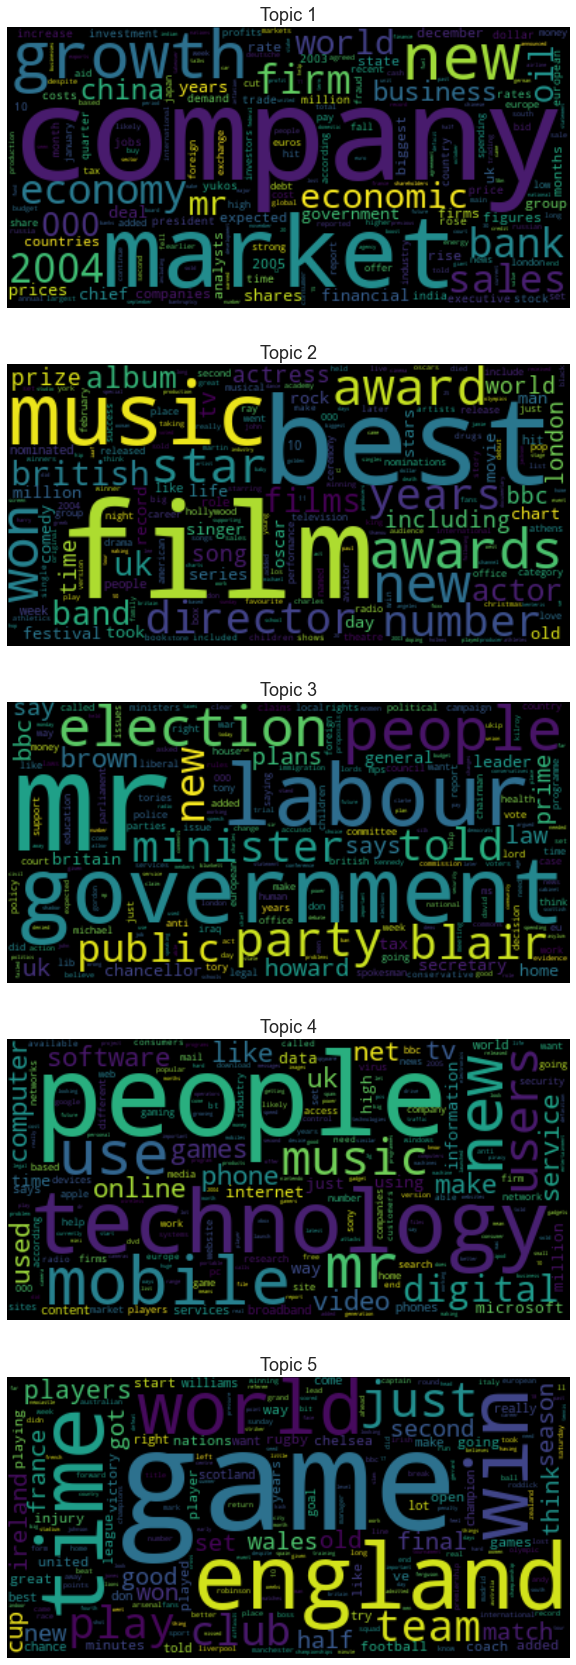

In [38]:
w = WordCloud()
fig, axes = plt.subplots(nrows=5, figsize=(15, 30))
axes = axes.flatten()
for t, (topic, freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w, interpolation='bilinear')
    axes[t].set_title(topic, fontsize=18)
    axes[t].axis('off')

## Visualize topic-word associations per document

In [39]:
dtm_ = pd.DataFrame(data=lda_all.transform(dtm),
                    columns=topic_labels,
                    index=docs.topic)
dtm_.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Business,0.757415,0.043291,0.001399,0.196532,0.001363
Business,0.936017,0.001356,0.059912,0.001354,0.001361
Business,0.976877,0.017347,0.001937,0.001917,0.001922
Business,0.994521,0.001373,0.001363,0.001368,0.001375
Business,0.989023,0.002714,0.002762,0.002725,0.002775


In [40]:
color_dict = OrderedDict()
color_dict['Topic 1'] = {'color': 'white', 'on_color': 'on_blue'}
color_dict['Topic 2'] = {'color': 'white', 'on_color': 'on_green'}
color_dict['Topic 3'] = {'color': 'white', 'on_color': 'on_red'}
color_dict['Topic 4'] = {'color': 'white', 'on_color': 'on_magenta'}
color_dict['Topic 5'] = {'color': 'blue', 'on_color': 'on_yellow'}
dtm_['article'] = docs.article.values
dtm_['heading'] = docs.heading.values
sample = dtm_[dtm_[topic_labels].gt(.05).all(1)]
sample

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,article,heading
topic,,,,,,,
Business,0.630684,0.114709,0.128678,0.065489,0.060440,One of Japan's best-known businessmen was arr...,Japanese mogul arrested for fraud
Entertainment,0.064855,0.319108,0.084398,0.225091,0.306548,Broadcaster Chris Evans has begun selling tho...,Chris Evans back on the market
Entertainment,0.055545,0.168249,0.363690,0.284121,0.128394,Angolan families who are attempting to track ...,TV show unites Angolan families
Entertainment,0.051780,0.742649,0.069040,0.065869,0.070662,"Scottish rock band Franz Ferdinand, who shot ...",Franz Ferdinand's art school lesson
Entertainment,0.229219,0.199995,0.417789,0.070954,0.082044,Proposals to open a museum dedicated to Jimi ...,Row threatens Hendrix museum plan
Entertainment,0.100635,0.634550,0.154238,0.055561,0.055016,"Stan Lee, the man responsible for a string of...",The comic book genius of Stan Lee
Entertainment,0.144835,0.280651,0.232055,0.230626,0.111833,Women in the UK film industry earn less than ...,Women in film 'are earning less'
Tech,0.291468,0.073499,0.108780,0.465605,0.060647,Car-maker Honda's humanoid robot Asimo has ju...,Humanoid robot learns how to run


In [41]:
colored_text = []
for word in sample.iloc[0, 5].split():
    try:
        topic = topics.loc[word.strip().lower()].idxmax()
        colored_text.append(colored(word, **color_dict[topic]))
    except:
        colored_text.append(word)

print(' '.join([colored(k, **v) for k, v in color_dict.items()]))
print('\n',sample.iloc[0, 6], '\n')
text = ' '.join(colored_text)
print(text)

Topic 1 Topic 2 Topic 3 Topic 4 Topic 5

 Japanese mogul arrested for fraud 

One of Japan's best-known businessmen was arrested on Thursday on charges of falsifying shareholder information and selling shares based on the false data. Yoshiaki Tsutsumi was once ranked as the world's richest man and ran a business spanning hotels, railways, construction and a baseball team. His is the latest in a series of arrests of top executives in Japan over business scandals. He was taken away in a van outside one of his Prince hotels in Tokyo. There was a time when Mr Tsutsumi seemed untouchable. Inheriting a large property business from his father in the 1960s, he became one of Japan's most powerful industrialists, with close connections to many of the country's leading politicians. He used his wealth and influence to bring the Winter Olympic Games to Nagano in 1998. But last year, he was forced to resign from all the posts he held in his business empire, after being accused of falsifying the shar